testing everything from scratch.

implementing things like line search...

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import targprop.datasets as ds
import targprop.operations as ops

import tensorflow as tf

In [4]:
from tqdm import tqdm

In [5]:
# params
batch_size = 1000
t_steps = 1000

In [165]:
# data
data = ds.mnist_data()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [166]:
# stuff
m_dim = data.inputs.shape[1]
p_dim = data.outputs.shape[1]
l_dim = [m_dim] + [100, 100] + [p_dim]
layers = len(l_dim) - 1

In [167]:
print "layer dimensions:", l_dim

layer dimensions: [784, 100, 100, 10]


In [168]:
# parameters
W = (layers+1)*[None]
b = (layers+1)*[None]
A = (layers+1)*[None]

In [169]:
def make_tf_L(layer, W_shape, b_shape, lr, act=tf.nn.tanh):
  """
    TODO: implement initialization as input option
    builds graph for layer-local training of W and b
    args:
      layer (int): which layer
      W_shape:
      b_shape:
      lr: learning rate
      act: activation function
    returns:
      training op
      merged summaries of this layer
  """
  with tf.name_scope('layer'+str(layer)+'_ff') as scope:

    #W = tf.get_variable(scope+'W', shape=W_shape, dtype=tf.float32, initializer=tf.orthogonal_initializer(0.95))
    W = tf.get_variable(scope+'W', shape=W_shape, dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
    b = tf.get_variable(scope+'b', shape=b_shape, dtype=tf.float32, initializer=tf.constant_initializer(0.))

    x_0 = tf.placeholder(tf.float32, shape=[None, W_shape[0]], name='input')
    y   = tf.placeholder(tf.float32, shape=[None, W_shape[1]], name='output')
    
    #loss = 0.5*tf.reduce_mean((act(tf.matmul(x_0, W) + b) - y)**2, name='loss') 
    loss = 0.5*tf.reduce_mean((tf.matmul(x_0, W) + b - y)**2, name='loss') 
    
    s1 = tf.summary.scalar('log_loss'+str(layer), tf.log(loss))
    s2 = tf.summary.histogram('W'+str(layer), W)
    s3 = tf.summary.histogram('b'+str(layer), b) 
    
    opt = tf.train.RMSPropOptimizer(lr) # rmsprop works *way* better than adam for local loss functions. unclear why.
    # opt = tf.train.GradientDescentOptimizer(lr) # rmsprop works *way* better than adam for local loss functions. unclear why.
    gvs = opt.compute_gradients(loss, var_list=[W, b])
    sg  = [tf.summary.scalar('norm_grad'+var.name[-3], tf.nn.l2_loss(grad)) for grad, var in gvs] # var.name = 'namescope/V:0' and we want just 'V'
    clipped_gvs = [(tf.clip_by_norm(grad, 100.), var) for grad, var in gvs] # hmmmmmm. clip by norm value?
    
    return opt.apply_gradients(clipped_gvs), tf.summary.merge([s1] + sg)

In [170]:
for l in range(1, layers+1):
  low = -np.sqrt(6.0/(l_dim[l-1] + l_dim[l]))
  high = np.sqrt(6.0/(l_dim[l-1] + l_dim[l]))
  W[l] = np.random.uniform(low=low, high=high, size=(l_dim[l-1], l_dim[l])).astype('float32') # Xavier initialization
  b[l] = 0.*np.ones((1, l_dim[l])).astype('float32')
  A[l] = np.concatenate((W[l], b[l]), axis=0)

In [171]:
learning_rate = 0.003

In [172]:
# for l in range(1, layers+1):
#   train_op_L[l], summary_ops[l] = make_tf_L(l, W_shape=(l_dim[l-1], l_dim[l]), 
#                                                b_shape=(1, l_dim[l]),
#                                                lr=learning_rate,
#                                                act=tf_acts[l])

In [173]:
# activations etc
x  = [3*[None] for i in range(layers+1)]
#x_ = [None for i in range(layers+1)] # augmented x, with vector of ones.
tx = [3*[None] for i in range(layers+1)]
dx = [3*[None] for i in range(layers+1)]
cx = [3*[None] for i in range(layers+1)] # for checking...

tW = [None for i in range(layers+1)]
tb = [None for i in range(layers+1)]

Losses = [3*[None] for i in range(layers+1)]
L_store = t_steps*[None]
acc_store = t_steps*[None]

In [174]:
lin = ops.linear()
add = ops.addition()
act = ops.relu()
idn = ops.identity()

In [175]:
def softmax(x):
  exp = np.exp(x)
  return exp/np.sum(exp, axis=1, keepdims=True)
def cross_entropy(z, y):
  return -np.mean(y*np.log(z))
def accuracy(z, y):
  return np.sum(np.equal(np.argmax(z,1), np.argmax(y,1))).astype('float32')/z.shape[0]

In [176]:
alpha_ = 1e-6

In [177]:
# first: check if leaky relu works
# second: check if interleaving strat works

In [178]:
tf.reset_default_graph()

In [179]:
ph = tf.placeholder(tf.float32, shape=[batch_size, l_dim[-1]])
sf = tf.nn.softmax(ph)

In [200]:
sess = tf.Session()
for t in tqdm(range(1000)):
  # get data
  x0 = data.inputs[:batch_size]
  y = data.outputs[:batch_size].astype('float32')
  
  # forward pass
  x[0][2] = x0
  for l in range(1, layers+1):
    x[l][0] = lin.f( x[l-1][2], W[l] )
    x[l][1] = add.f( x[l][0], b[l] )
    if l==layers:
      x[l][2] = idn.f( x[l][1] )
    else:
      x[l][2] = act.f( x[l][1] )
      
  # top loss stuff
  z = sess.run(sf, feed_dict={ph: x[-1][2]} )
  L = cross_entropy(z, y)
  
  # line search
  alpha = np.linspace(0, 10, 100)
  L_new = np.zeros_like(alpha)
  acc = np.zeros_like(alpha)
  for i,a in enumerate(alpha):
    L_new[i] = cross_entropy(sess.run(sf, feed_dict={ph: x[-1][2] - a*(z - y)} ), y)
    acc[i] = accuracy(sess.run(sf, feed_dict={ph: x[-1][2] - a*(z - y)} ),y)
  alpha = alpha[np.argmax(acc)]
  
  # loss targets
  dx[-1][2] = z - y
  tx[-1][2] = x[-1][2] - alpha*dx[-1][2]
  
  # interweaving backward pass...
  for l in range(layers, 0, -1):
    if l == layers:
      tx[l][1] = idn.f_inv( tx[l][2], None )
    else:
      tx[l][1] = act.f_inv( tx[l][2], x[l][1] )
    
    # update b
    Losses[l][1] = np.mean((x[l][1] - tx[l][1])**2.)
    b[l] = b[l] - alpha_*np.mean(x[l][1] - tx[l][1], axis=0, keepdims=True)
    
    # assign target
    tx[l][0] = add.f_inv( tx[l][1], None, b[l] )

    # update W
    Losses[l][0] = np.mean((x[l][0] - tx[l][0])**2.)
    W[l] = W[l] - alpha_*(np.dot(x[l][0].T - tx[l][0].T, x[l-1][2])).T
    
    # assign target
    tx[l-1][2] = lin.f_inv( tx[l][0], x[l-1][2], W[l] )
  
  L_store[t] = L
  acc_store[t] = accuracy( x[-1][2], y )
  

100%|██████████| 1000/1000 [03:17<00:00,  5.09it/s]


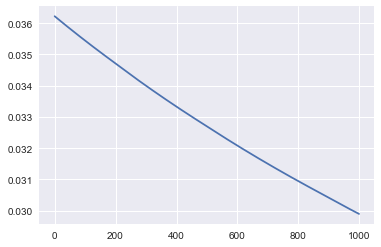

In [201]:
plt.plot(L_store)

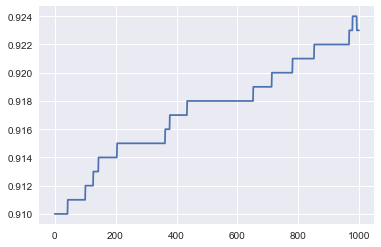

In [202]:
plt.plot(acc_store)

In [ ]:
# backward pass
for l in range(layers, 0, -1):
  if l == layers:
    tx[l][1] = idn.f_inv( tx[l][2], None )
  else:
    tx[l][1] = act.f_inv( tx[l][2], None )
  
  tx[l][0]   = add.f_inv( tx[l][1], None, b[l] )
  tx[l-1][2] = lin.f_inv( tx[l][0], x[l-1][2], W[l] )

`x[0][2]
--W[1]--> x[1][0] --b[1]--> x[1][1] --f--> x[0][2]
--W[2]--> x[2][0] --b[2]--> x[2][1] --f--> x[1][2]
--W[3]--> x[3][0] --b[3]--> x[3][1] --I--> x[3][2]`

In [ ]:
# check targets
cx[0][2] = tx[0][2]
for l in range(1, layers+1):
  cx[l][0] = lin.f( cx[l-1][2], W[l] )
  cx[l][1] = add.f( cx[l][0],   b[l] )
  if l==layers:
    cx[l][2] = idn.f( cx[l][1] )
  else:
    cx[l][2] = act.f( cx[l][1] )

# check inverses

In [ ]:
# inverse checks
b_test = 100*np.random.randn(1, 100)
W_test = 10000*np.random.randn(100, 50)
x_test = 1000000*np.random.randn(1000, 100)
print np.sum(np.abs(x_test - add.f_inv( add.f(x_test, b_test ), [], b_test)))
print np.sum(np.abs(x_test - lin.f_inv( lin.f(x_test, W_test ), x_test, W_test)))
print np.sum(np.abs(x_test - act.f_inv( act.f(x_test), x_test)))

# check affine model

# old:

In [ ]:
# dimensions
n0 = 1 # input dimension / number of input units
n1 = 2 # hidden dimension / number of hidden layer units
n2 = 1  # output dimension

th1 = 3*np.pi/8
W1 = np.array([[np.cos(th1)], [np.sin(th1)]]) # size 2 x 1
th2 = -2*np.pi/8
W2 = np.array([[np.cos(th2) , np.sin(th2)]]) # size 1 x 2

# inputs
num_examples = 21

x0 = np.linspace(-2, 2, num_examples)[np.newaxis, :]

## define operations

In [ ]:
lin = ops.linear()
tanh = ops.tanh()

## forward pass on model

In [ ]:
# forward pass on the model
h1 = lin.f( W1, x0 )
x1 = tanh.f( h1 )
x2 = lin.f( W2, x1 )

## train model

In [ ]:
W2

In [ ]:
def train(prop_method, gamma=1, num_steps=10, alpha=0.5):

  W1_est = num_steps*[None]
  W2_est = num_steps*[None]
  
  h1_est = num_steps*[None]
  x1_est = num_steps*[None]
  x2_est = num_steps*[None]

  loss = num_steps*[None]
  loss_1 = num_steps*[None]

  W1_tar = num_steps*[None]
  W1_tar = num_steps*[None]
  
  h1_tar = num_steps*[None]
  x1_tar = num_steps*[None]

  W1_d = num_steps*[None]
  W2_d = num_steps*[None]
  
  h1_d = num_steps*[None]
  x1_d = num_steps*[None]

  th3 = 1*np.pi/8
  W1_est[0] = np.array([[np.cos(th3)], [np.sin(th3)]])
  W2_est[0] = np.array([[np.cos(th3), np.sin(th3)]])
  
  for t in range(num_steps):
    # forward:
    h1_est[t] = lin.f( W1_est[t], x0 )
    x1_est[t] = tanh.f( h1_est[t] )
    x2_est[t] = lin.f( W2_est[t], x1_est[t] )
    loss[t] = 0.5*np.mean((x2_est[t] - x2)**2)
    
    # backward:
    if prop_method == 'tp_inv':
      x1_tar[t] = lin.f_inv( x2.T, x1_est[t].T, W2.T ).T
      h1_tar[t] = tanh.f_inv( x1_tar[t], h1_est[t], th=1e-12 )
      W1_tar[t] = lin.f_inv( h1_tar[t], W1_est[t], x0 )
      W2_tar[t] = lin.f_inv( x2, W2_est[t], h1_est[t] )
    elif prop_method == 'tp_rinv':
      x1_tar[t] = lin.f_rinv( x2.T, x1_est[t].T, W2.T , gamma=gamma ).T
      h1_tar[t] = tanh.f_rinv( x1_tar[t], h1_est[t], gamma=gamma, scipy_fmin=True )
      W1_tar[t] = lin.f_rinv( h1_tar[t], W1_est[t], x0 )  
      W2_tar[t] = lin.f_rinv( x2, W2_est[t], h1_est[t] )
    elif prop_method == 'bp':
      # backward derivatives
      x1_d[t] = lin.df( x2_est[t].T - x2.T, h1_est[t].T, W2.T ).T
      h1_d[t] = tanh.df( x1_d[t], h1_est[t] )
      W1_d[t] = lin.df( h1_d[t], W1_est[t], x0 )
      W2_d[t] = lin.df( x2_est[t] - x2, )
      
      x1_tar[t] = x1_est[t] - x1_d[t]
      h1_tar[t] = h1_est[t] - h1_d[t]
      W1_tar[t] = W1_est[t] - W1_d[t]
    elif prop_method == 'tp_then_bp':
      x1_tar[t] = lin.f_rinv( x2.T, x1_est[t].T, W2.T , gamma=gamma ).T
      h1_tar[t] = tanh.f_rinv( x1_tar[t], h1_est[t], gamma=gamma, scipy_fmin=False )
      W1_d[t] = lin.df( h1_est[t] - h1_tar[t], W1_est[t], x0 )
      
      W1_tar[t] = W1_est[t] - W1_d[t]
    
    loss_1[t] = 0.5*np.mean((x1_est[t] - x1_tar[t])**2)          
    
    if t < num_steps - 1:
      W1_est[t+1] = W1_est[t] - alpha*(W1_est[t] - W1_tar[t])
      
  return { 'W1_est':W1_est, 'h1_est':h1_est, 'x1_est':x1_est, 'x2_est':x2_est,
           'loss':loss, 'loss1':loss_1,
           'W1_tar':W1_tar, 'h1_tar':h1_tar, 'x1_tar':x1_tar,
           'W1_d':W1_d, 'h1_d':h1_d, 'x1_d':x1_d }

In [ ]:
num_steps = 1000

datasets = {}
datasets['bp'] = train('bp', num_steps=num_steps, alpha=0.01)
datasets['tp_inv'] = train('tp_inv', num_steps=num_steps, alpha=1)
datasets['tp_rinv'] = train('tp_rinv', gamma=0.1, num_steps=num_steps, alpha=1)
# for i, gamma in enumerate([1, 30, 10]):
#   datasets['rinv_'+str(gamma)] = train('tp_rinv', num_steps=num_steps, gamma=gamma, alpha=1.0)
#   datasets['rinv_'+str(gamma)]['idx'] = i
  
#datasets['tp_then_bp'] = train('tp_then_bp', num_steps=num_steps, gamma=1e0, alpha=0.01)

In [ ]:
def plot_x2s(data, title=None):
  num_steps = len(data['x2_est'])
  sns.set_palette(sns.color_palette("RdBu", num_steps+1))
  f = plt.plot(x2.T,'ko')[0]
  for t in range(num_steps):
    plt.plot(data['x2_est'][t].T,'o')
  plt.xlim([-1, num_examples+1])
  f.axes.xaxis.set_ticks(np.arange(0, num_examples+1))
  plt.xlabel('examples')
  plt.ylabel('x2')
  plt.title(title)
  plt.show()


In [ ]:
for key, val in datasets.items():
  plot_x2s(val, key)


In [ ]:
def plot_loss(data, ax, label):
  ax.plot(np.log(data['loss']), '-', label=label)
  ax.plot(np.log(data['loss1']), '-', label=label)

In [ ]:
sns.set_palette(sns.color_palette("Set1", 10))

fig = plt.figure()
ax = fig.add_subplot(111)

for key, val in datasets.items():
  plot_loss(val, ax, key)

plt.legend()

In [ ]:
# plot W1 loss...
wa, wb = np.meshgrid(np.linspace(-3,3,500), np.linspace(-3,3,500))

In [ ]:
l_grid = np.zeros_like(wa)
for i in range(wa.shape[0]):
  for j in range(wa.shape[0]):
    l_grid[i,j] = 0.5*np.mean((np.dot( W2, np.tanh( np.dot( np.array([[wa[i,j]], [wb[i,j]]]), x0 ) ) ) - x2)**2)


In [ ]:
def plot_traj(data, ax, c, label=None):
  w1_scatter = np.stack(data['W1_est'])
  ax.plot(w1_scatter[:,0,0], w1_scatter[:,1,0], '-', c=c, label=label)

In [ ]:
cmap = sns.color_palette('Set1', 100)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

ax.contour(wa, wb, np.log(l_grid), 10)

for i, (key, val) in enumerate(datasets.items()):
  plot_traj(val, ax, cmap[i], key)

ax.plot(W1[0], W1[1],'ko')

axify(ax, [-3, 3])
plt.xlim([-0.1, 1.5])
plt.ylim([-0.1, 1.5])
plt.legend()
#plt.axis('square')

### visualize learning

In [ ]:
cmap = sns.color_palette("RdBu", num_examples)
sort_inds = np.argsort(x2[0])

In [ ]:
cmap_sorted = [cmap[i] for i in np.argsort(sort_inds)]

In [ ]:
def axify(ax, lims=None):
  ax.axis('equal')
  if not lims:
    lims = ax.get_xlim() + ax.get_ylim()
    lims = min(lims), max(lims)
  ax.set_xlim(lims)
  ax.set_ylim(lims)

  ax.xaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 0.5))
  ax.yaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 0.5))
  
  ax.hlines([0], *ax.get_xlim(), linewidth=0.75, alpha=0.5)
  ax.vlines([0], *ax.get_ylim(), linewidth=0.75, alpha=0.5)


In [ ]:
def add_scatterplot(fig, nrows, ncols, subplot, data, args):
  
  if data.shape[0]==1:
    rng = data.max() - data.min()
    ax = fig.add_subplot(nrows, ncols, subplot)
    #ax.scatter(data[0,:], rng*0.0*(np.random.rand(1, data.shape[1])-0.5), **args)
    ax.scatter(data[0,:], np.linspace(-0.05, 0.05, data.shape[1]), **args)
    axify(ax)
    ax.set_xlim((data.min()-rng*0.1, data.max()+rng*0.1))
    ax.set_ylim((-rng*0.1, rng*0.1))
    ax.yaxis.set_ticks([0])

  elif data.shape[0]==2:
    ax = fig.add_subplot(nrows, ncols, subplot)
    ax.scatter(data[0,:], data[1,:], **args)
    axify(ax)
  elif data.shape[0]>2:
    ax = fig.add_subplot(nrows, ncols, subplot, projection='3d')
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

In [ ]:
def append_scatterplot(ax, data, args):

  if data.shape[0]==1:
    ax.scatter(data[0,:], np.zeros_like(data), **args)
  elif data.shape[0]==2:
    ax.scatter(data[0,:], data[1,:], **args)
  elif data.shape[0]>2:
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

In [ ]:
def get_subspaces(A, r):
  u,s,v = np.linalg.svd(A, full_matrices=True)
  ss = {'im': u[:,:r], 'ker': v[r:].T, 'coim': v[:r].T, 'coker': u[:,r:]}
  return ss

In [ ]:
W2_ss = get_subspaces(W2, 1)
ker_line = np.dot(W2_ss['ker'], np.linspace(-5, 5, 201)[np.newaxis, :])
ker_lines = ker_line[:,:,np.newaxis] + np.dot(np.linalg.pinv(W2), x2)[:,np.newaxis,:]

In [ ]:
h1_lines = tanh.f_inv(ker_lines, 0, 1e-15)

In [ ]:
sns.palplot(cmap)

rows = min(num_steps+1, 6)
cols = 5
mult = 5

fig = plt.figure(figsize=(mult*cols, mult*rows))

args = {}
args['c'] = cmap_sorted
args['s'] = 70
args['linewidth'] = 0.5

args2 = {}
args2['c'] = cmap_sorted
args2['s'] = 30
args2['linewidth'] = 2
args2['marker'] = 'x'

args3 = {}
args3['c'] = cmap_sorted
args3['s'] = 30
args3['linewidth'] = 1
args3['marker'] = 'v'

ax = []

# plot inputs
i = 0
ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

i=1
ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))
#ax.append(fig.add_subplot(rows, cols, i+1))
for j in np.arange(0, num_examples, 1):
  ax[-1].plot(h1_lines[0,:,j], h1_lines[1,:,j], c=cmap_sorted[j], linewidth=2, alpha=0.75, zorder=0)
axify(ax[-1], [-3,3])
#ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))
#ax[-1].contour
#append_scatterplot(ax[-1], h1_target, args3)

# plot ker_lines
i=2
ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))
#ax.append(fig.add_subplot(rows, cols, i+1))
for j in np.arange(0, num_examples, 1):
  ax[-1].plot(ker_lines[0,:,j], ker_lines[1,:,j], c=cmap_sorted[j], linewidth=2, alpha=0.75, zorder=0)
axify(ax[-1], [-1,1])
  
#ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))
#append_scatterplot(ax[-1], x1_target, args3)

# plot outputs
i=3
ax.append(add_scatterplot(fig, rows, cols, i+1, x2, args))

# for t in range(rows-1):
#   i = (t+1)*cols+0
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

#   i=(t+1)*cols+1
#   ax.append(add_scatterplot(fig, rows, cols, i+1, h1_est[t], args))
#   append_scatterplot(ax[-1], h1_tar[t], args2)
#   append_scatterplot(ax[-1], h1_est[t] + h1_d[t], args3)

#   i=(t+1)*cols+2
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x1_est[t], args))
#   append_scatterplot(ax[-1], x1_tar[t], args2)
#   append_scatterplot(ax[-1], x1_est[t] + x1_d[t], args3)
  
#   i=(t+1)*cols+3
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t], args))

#   i=(t+1)*cols+4
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t] - x2, args))
  
# # print "W1=\n", W1
# # print "\nW2=\n", W2
# # print "\nW1 initial guess = \n", W1_est[-1]


In [ ]:
sns.palplot(cmap)

rows = min(num_steps+1, 6)
cols = 5
mult = 5

fig = plt.figure(figsize=(mult*cols, mult*rows))

args = {}
args['c'] = cmap_sorted
args['s'] = 70
args['linewidth'] = 0.5

args2 = {}
args2['c'] = cmap_sorted
args2['s'] = 30
args2['linewidth'] = 2
args2['marker'] = 'x'

args3 = {}
args3['c'] = cmap_sorted
args3['s'] = 30
args3['linewidth'] = 1
args3['marker'] = 'v'

ax = []

i = 0
ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

i=1
ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))
#ax[-1].contour
#append_scatterplot(ax[-1], h1_target, args3)

i=2
ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))
#append_scatterplot(ax[-1], x1_target, args3)

i=3
ax.append(add_scatterplot(fig, rows, cols, i+1, x2, args))

for t in range(rows-1):
  i = (t+1)*cols+0
  ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

  i=(t+1)*cols+1
  ax.append(add_scatterplot(fig, rows, cols, i+1, h1_est[t], args))
  append_scatterplot(ax[-1], h1_tar[t], args2)
  append_scatterplot(ax[-1], h1_est[t] + h1_d[t], args3)

  i=(t+1)*cols+2
  ax.append(add_scatterplot(fig, rows, cols, i+1, x1_est[t], args))
  append_scatterplot(ax[-1], x1_tar[t], args2)
  append_scatterplot(ax[-1], x1_est[t] + x1_d[t], args3)
  
  i=(t+1)*cols+3
  ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t], args))
  axify(ax[-1], [-.5, .5])

  i=(t+1)*cols+4
  ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t] - x2, args))
  
# print "W1=\n", W1
# print "\nW2=\n", W2
# print "\nW1 initial guess = \n", W1_est[-1]


In [ ]:
def plot3d_lines(ax):
  args = {'linewidth':0.5, 'alpha':0.5}
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  zlim = ax.get_zlim()
  for i in range(3):
    ax.plot([0,0], [0,0], [-zlim, zlim], 'k', **args)
    ax.plot([0,0], [-ylim, ylim], [0,0], 'k', **args)
    ax.plot([-xlim, xlim], [0,0], [0,0], 'k', **args)


In [ ]:
def get_subspaces(A_, r):
    ''' return: a dict containing the four fundamental subspaces of a matrix A '''
    u,s,v = np.linalg.svd(A_, full_matrices=True)
    ss = {'im': u[:,:r], 'ker': v[r:].T, 'coim': v[:r].T, 'coker': u[:,r:]}
    return ss

def plot_vecline(V, i=0, color=0):
    ''' plots the 1d subspace (line) spanned by one vector V '''
    VV = np.concatenate((-10*V, 10*V), axis=1)
    ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=2.0)
    
def plot_quotient(V, W, i=0, color=5):
    ''' plots elements (lines) of the quotient space V/W 
        todo: replace n with sv or 1/sv
    '''
    for n in np.arange(-3,3.1,0.5):
        VV = np.concatenate((-10*V, 10*V), axis=1)
        VV = VV + n*W
        ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=0.5)

def square_axes(i=0):
    ''' make axis look nice '''
    fig.axes[i].axhline(0, color='w', linewidth=3.5)
    fig.axes[i].axvline(0, color='w', linewidth=3.5)
    fig.axes[i].set_xlim(-3.5,3.5)
    fig.axes[i].set_ylim(-3.5,3.5)
    fig.axes[i].set_aspect(1)
    fig.axes[i].get_xaxis().set_ticklabels([])
    fig.axes[i].get_yaxis().set_ticklabels([])